### Define utility functions

In [0]:
%tensorflow_version 1.x
import csv

import numpy as np
import pandas as pd
import pylab as plt
import tensorflow as tf

TEXT_COLOR = 'black'
plt.rc('xtick', color=TEXT_COLOR)
plt.rc('ytick', color=TEXT_COLOR)


def plot_graphs(data, labels=None, figsize=(16,6), title=None):
    if labels is None:
        labels = [""] * len(data)
    assert len(labels) == len(data)

    # plot 2 graphs side-by-side
    fig = plt.figure(figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlabel("Epoch", color=TEXT_COLOR)
    ax1.set_ylabel("Cross entropy loss", color=TEXT_COLOR)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel("Epoch", color=TEXT_COLOR)
    ax2.set_ylabel("Accuracy", color=TEXT_COLOR)

    for label, (train_loss, test_acc) in zip(labels, data):
        ax1.plot(range(len(train_loss)), train_loss, label=label)
        ax2.plot(range(len(test_acc)), test_acc, label=label)

    if len(data) > 1:
        ax1.legend()
        ax2.legend()

    plt.show()


def read_data(max_seq_length, granularity='char'):
    x_train, y_train, x_test, y_test = [], [], [], []

    with open('train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_train.append(row[2])
            y_train.append(int(row[0]))

    with open('test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_test.append(row[2])
            y_test.append(int(row[0]))

    x_train = pd.Series(x_train)
    y_train = pd.Series(y_train)
    x_test = pd.Series(x_test)
    y_test = pd.Series(y_test)

    if granularity == 'char':
        processor = tf.contrib.learn.preprocessing.ByteProcessor(max_seq_length)
    elif granularity == 'word':
        processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_seq_length)
    else:
        raise Exception("Unknown granularity", granularity)

    x_train = np.array(list(processor.fit_transform(x_train)))
    x_test = np.array(list(processor.transform(x_test)))
    y_train = y_train.values
    y_test = y_test.values

    return x_train, y_train, x_test, y_test

### Define model class

##### Set up tensorflow's training infrastructure

In [0]:
from time import time

import numpy as np
import tensorflow as tf

RANDOM_SEED = 10

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

TF_SESSION = None

def reset_states():
    global TF_SESSION
    if TF_SESSION and not TF_SESSION._closed:
        TF_SESSION.close()
        TF_SESSION = None

    tf.reset_default_graph()
    np.random.seed(RANDOM_SEED)
    tf.random.set_random_seed(RANDOM_SEED)


def train(model, epochs, learning_rate, batch_size, x_train, y_train, x_test, y_test, 
          *, gradient_clipping_threshold=None, dropout_rate=0.0, log_interval=50):
    global TF_SESSION
    TF_SESSION = tf.InteractiveSession()

    train_op = tf.train.AdamOptimizer(learning_rate)
    if gradient_clipping_threshold is not None:
        computed = train_op.compute_gradients(model.entropy)
        # clipped = [(tf.clip_by_value(
        #     grad, -gradient_clipping_threshold, gradient_clipping_threshold), var) for grad, var in computed]
        clipped = [(tf.clip_by_norm(grad, gradient_clipping_threshold), var) for grad, var in computed]
        train_op = train_op.apply_gradients(clipped)
    else:
        train_op = train_op.minimize(model.entropy)

    TF_SESSION.run(tf.global_variables_initializer())

    train_loss = []
    test_acc = []
    start_time = time()
    for e in range(epochs):
        # shuffle training data
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        x_train = x_train[idx]
        y_train = y_train[idx]

        # run gradient descent for each batch
        for j in range(0, x_train.shape[0], batch_size):
            batch_x = x_train[j:j + batch_size]
            batch_y = y_train[j:j + batch_size]
            TF_SESSION.run(train_op, feed_dict={
                model.x: batch_x, model.y_: batch_y, model.dropout_rate: dropout_rate})

        # run gradient descent for the remaining incomplete batch
        if j < x_train.shape[0]:
            TF_SESSION.run(train_op, feed_dict={
                model.x: x_train[j:], model.y_: y_train[j:], model.dropout_rate: dropout_rate})

        # calculate training loss and test accuracy
        TF_SESSION.run(tf.local_variables_initializer())
        train_loss.append(TF_SESSION.run(model.entropy, {model.x: x_train, model.y_: y_train}))
        TF_SESSION.run([model.acc_op], {model.x: x_test, model.y_: y_test})
        test_acc.append(TF_SESSION.run([model.acc])[0])

        if e % log_interval == 0 or e == (epochs - 1):
            print(f"iter: {e:<3} | train_loss: {train_loss[e]:<7.5f} | test_acc: {test_acc[e]:.5f}")
    print(f"Done. (Total time taken: {time() - start_time:.2f} seconds | " + 
          f"Highest test accuracy: {max(test_acc):.5f} at epoch {np.argmax(test_acc)})\n")

    return train_loss, test_acc

##### Convolutional Neural Network (CNN)

In [0]:
import tensorflow as tf


class CNN:
    def __init__(self, conv_layer_config, num_labels, max_seq_length, vocab_size, embedding_dim=None):
        # Input tensors
        self.x = tf.placeholder(tf.int64, [None, max_seq_length])
        self.y_ = tf.placeholder(tf.int64)
        
        # Input layer
        if embedding_dim is None:
            # use one-hot encoding
            self.input_layer = tf.reshape(tf.one_hot(self.x, vocab_size), [-1, max_seq_length, vocab_size, 1])
        else:
            # use word embedding
            self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)
            self.input_layer = tf.reshape(self.embedding_layer(self.x), [-1, max_seq_length, embedding_dim, 1])
        
        self.dropout_rate = tf.placeholder_with_default(0.0, shape=())

        # Convolution layers
        self.conv_layers = []
        self.pool_layers = []
        for i, (layer_name, configs) in enumerate(conv_layer_config.items()):
            with tf.variable_scope(layer_name):
                conv = tf.layers.conv2d(
                    self.input_layer if i == 0 else self.pool_layers[-1],
                    filters = configs['num_filters'],
                    kernel_size = configs['filter_size'],
                    padding = configs['filter_padding'],
                    activation = tf.nn.relu
                )
                pool = tf.layers.max_pooling2d(
                    conv,
                    pool_size = configs['pool_size'],
                    strides = configs['pool_stride'],
                    padding = configs['pool_padding']
                )
                
                self.conv_layers.append(tf.layers.dropout(inputs=conv, rate=self.dropout_rate))
                self.pool_layers.append(tf.layers.dropout(inputs=pool, rate=self.dropout_rate))
        
        # Output layer
        self.dense_inputs = tf.squeeze(tf.reduce_max(self.pool_layers[-1], 1), squeeze_dims=[1])
        self.logits = tf.layers.dense(self.dense_inputs, num_labels, activation=None)

        # Loss function
        self.entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(self.y_, num_labels), logits=self.logits)
        )

        # Accuracy metrics
        self.acc, self.acc_op = tf.metrics.accuracy(
            labels=self.y_, predictions=tf.argmax(tf.nn.softmax(self.logits), 1)
        )

##### Recurrent Neural Network (RNN)

In [0]:
import tensorflow as tf


class RNN:
    def __init__(self, hidden_dim, num_labels, max_seq_length, vocab_size, 
                 num_layers=1, cell_type='gru', embedding_dim=None):
        # Input tensors
        self.x = tf.placeholder(tf.int64, [None, max_seq_length])
        self.y_ = tf.placeholder(tf.int64)
        
        # Input layer
        if embedding_dim is None:
            # use one-hot encoding
            self.input_layer = tf.reshape(tf.one_hot(self.x, vocab_size), [-1, max_seq_length, vocab_size])
        else:
            # use word embedding
            self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)
            self.input_layer = tf.reshape(self.embedding_layer(self.x), [-1, max_seq_length, embedding_dim])
        self.input_layer = tf.unstack(self.input_layer, axis=1)

        self.dropout_rate = tf.placeholder_with_default(0.0, shape=())

        # Recurrent layers
        cell_constructor = None
        if cell_type == 'vanilla':
            cell_constructor = tf.nn.rnn_cell.BasicRNNCell
        elif cell_type == 'gru':
            cell_constructor = tf.nn.rnn_cell.GRUCell
        elif cell_type == 'lstm':
            cell_constructor = tf.nn.rnn_cell.LSTMCell
        else:
            raise Exception("Unknown cell_type", cell_type)

        self.rnn_cells = []
        for i in range(num_layers):
            rnn_cell = tf.nn.rnn_cell.DropoutWrapper(
                cell = cell_constructor(hidden_dim), 
                input_keep_prob=(1 - self.dropout_rate), 
                output_keep_prob=(1 - self.dropout_rate),
                name=f"rnn_cell_{i}"
            )
            self.rnn_cells.append(rnn_cell)

        self.outputs, _ = tf.nn.static_rnn(
            tf.nn.rnn_cell.MultiRNNCell(self.rnn_cells), self.input_layer, dtype=tf.float32
        )

        # Output layer
        self.logits = tf.layers.dense(self.outputs[-1], num_labels, activation=None)

        # Loss function
        self.entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=tf.one_hot(self.y_, num_labels), logits=self.logits
            )
        )

        # Accuracy metrics
        self.acc, self.acc_op = tf.metrics.accuracy(
            labels=self.y_, predictions=tf.argmax(tf.nn.softmax(self.logits), 1)
        )

### Define global variables

In [0]:
NUM_LABEL = 15
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = 256

BATCH_SIZE = 128
LEARING_RATE = 0.01

In [0]:
# cache training statistics for comparisons
STATISTICS = dict()

### Character-level CNN

iter: 0   | train_loss: 1.91138 | test_acc: 0.28857
iter: 50  | train_loss: 0.06364 | test_acc: 0.55286
iter: 100 | train_loss: 0.02023 | test_acc: 0.55714
iter: 150 | train_loss: 0.01312 | test_acc: 0.56429
iter: 199 | train_loss: 0.01674 | test_acc: 0.53714
Done. (Total time taken: 87.85 seconds | Highest test accuracy: 0.57571 at epoch 20)



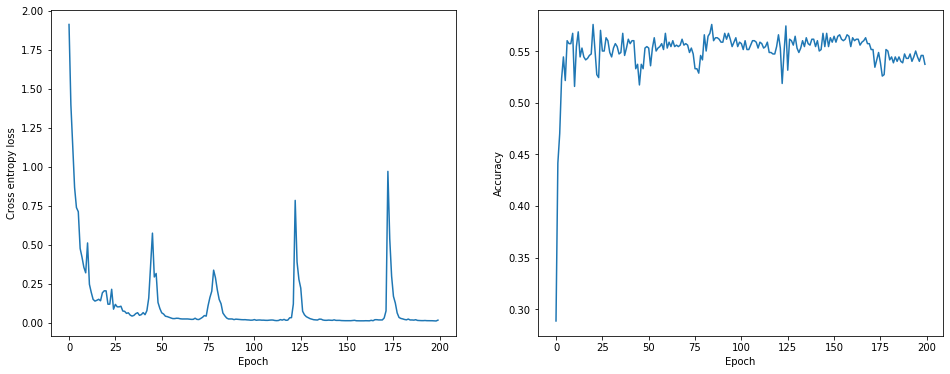

In [8]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
cnn_config = {
    "C1_S1": {
        'num_filters': 10,
        'filter_size': [20, 256],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    },
    "C2_S2": {
        'num_filters': 10,
        'filter_size': [20, 1],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    }
}
model = CNN(cnn_config, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE)

# 4. train neural network
num_epochs = 200
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-cnn"] = stats

### Word-level CNN

iter: 0   | train_loss: 1.66306 | test_acc: 0.32571
iter: 50  | train_loss: 0.00003 | test_acc: 0.78429
iter: 100 | train_loss: 0.00001 | test_acc: 0.78571
iter: 150 | train_loss: 0.00000 | test_acc: 0.78429
iter: 199 | train_loss: 0.00000 | test_acc: 0.78571
Done. (Total time taken: 43.41 seconds | Highest test accuracy: 0.79143 at epoch 26)



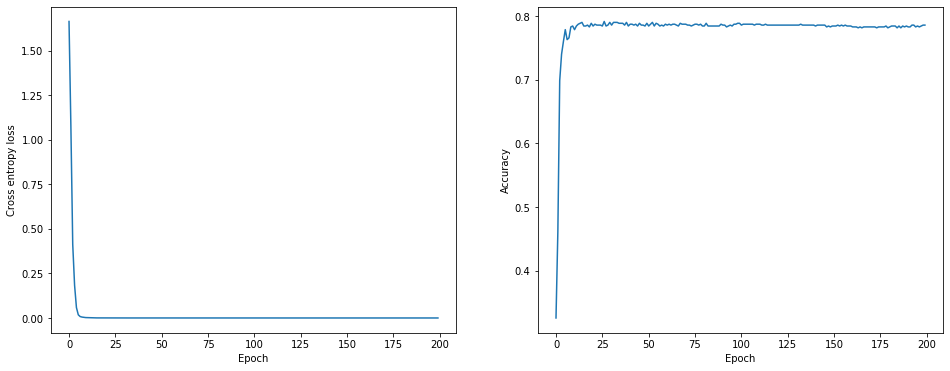

In [9]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
cnn_config = {
    "C1_S1": {
        'num_filters': 10,
        'filter_size': [20, 20],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    },
    "C2_S2": {
        'num_filters': 10,
        'filter_size': [20, 1],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    }
}
vocab_size = np.amax(x_train) + 1
model = CNN(cnn_config, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, embedding_dim=20)

# 4. train neural network
num_epochs = 200
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-cnn"] = stats

### Character-level GRU

iter: 0   | train_loss: 2.57220 | test_acc: 0.13286
iter: 50  | train_loss: 0.16136 | test_acc: 0.72857
iter: 100 | train_loss: 0.33827 | test_acc: 0.69714
iter: 150 | train_loss: 0.00785 | test_acc: 0.72286
iter: 199 | train_loss: 0.00799 | test_acc: 0.73857
Done. (Total time taken: 520.90 seconds | Highest test accuracy: 0.74714 at epoch 102)



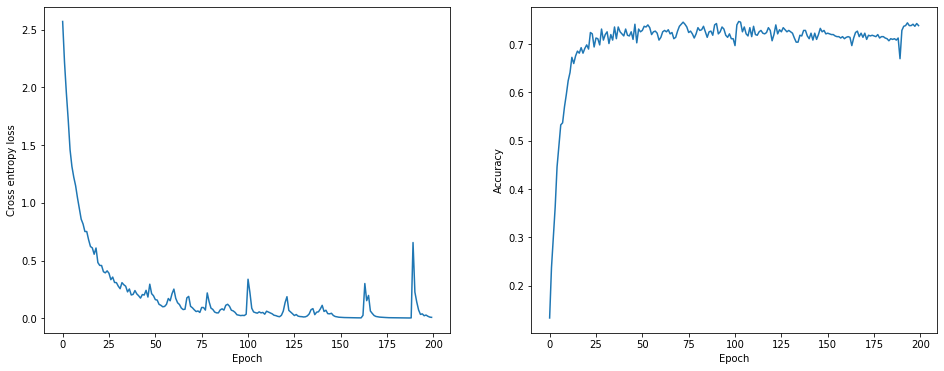

In [10]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE)

# 4. train neural network
num_epochs = 200
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-gru"] = stats

### Word-level GRU

iter: 0   | train_loss: 2.40589 | test_acc: 0.16000
iter: 50  | train_loss: 0.00041 | test_acc: 0.85286
iter: 100 | train_loss: 0.00008 | test_acc: 0.84714
iter: 150 | train_loss: 0.00002 | test_acc: 0.84429
iter: 199 | train_loss: 0.00001 | test_acc: 0.83000
Done. (Total time taken: 606.59 seconds | Highest test accuracy: 0.86000 at epoch 24)



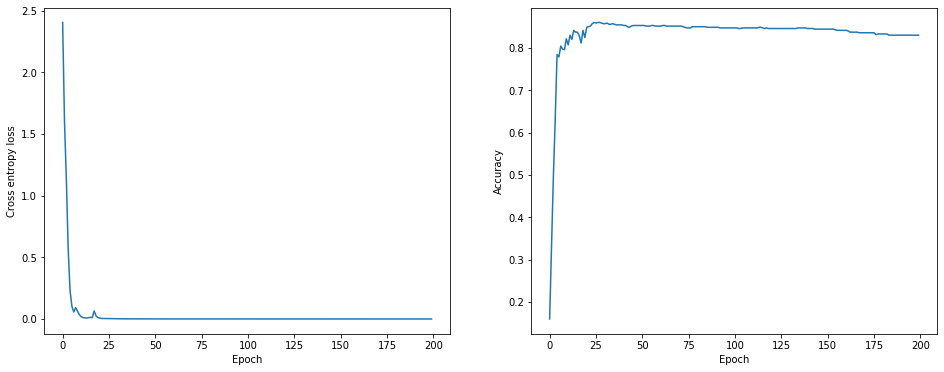

In [11]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
vocab_size = np.amax(x_train) + 1
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, embedding_dim=20)

# 4. train neural network
num_epochs = 200
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-gru"] = stats

### Add dropouts

##### character-level CNN with dropouts

iter: 0   | train_loss: 1.91138 | test_acc: 0.28857
iter: 50  | train_loss: 0.04369 | test_acc: 0.56571
iter: 100 | train_loss: 0.04852 | test_acc: 0.55286
iter: 150 | train_loss: 0.01824 | test_acc: 0.55857
iter: 199 | train_loss: 0.02140 | test_acc: 0.55429
Done. (Total time taken: 83.46 seconds | Highest test accuracy: 0.58000 at epoch 175)



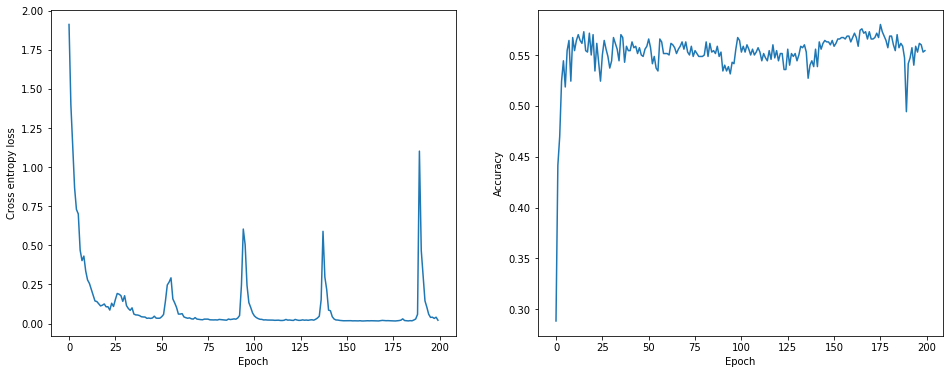

In [12]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
cnn_config = {
    "C1_S1": {
        'num_filters': 10,
        'filter_size': [20, 256],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    },
    "C2_S2": {
        'num_filters': 10,
        'filter_size': [20, 1],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    }
}
model = CNN(cnn_config, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-cnn-dropout"] = stats

##### word-level CNN with dropouts

iter: 0   | train_loss: 1.66306 | test_acc: 0.32571
iter: 50  | train_loss: 0.00003 | test_acc: 0.77143
iter: 100 | train_loss: 0.00001 | test_acc: 0.77000
iter: 150 | train_loss: 0.00000 | test_acc: 0.77000
iter: 199 | train_loss: 0.00000 | test_acc: 0.76857
Done. (Total time taken: 44.01 seconds | Highest test accuracy: 0.78143 at epoch 5)



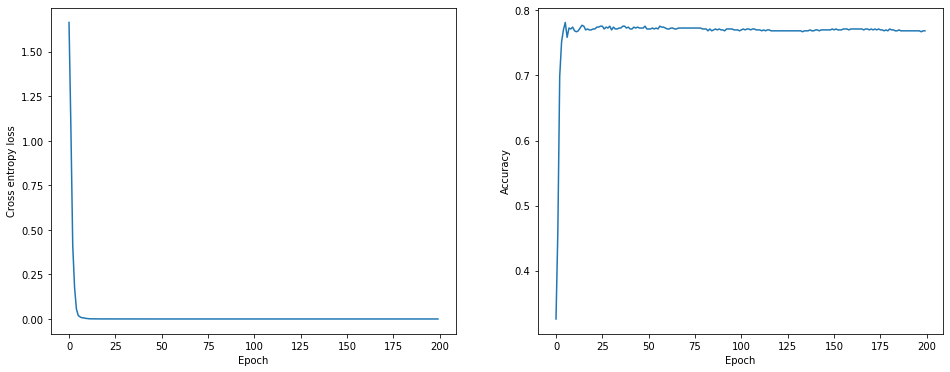

In [13]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
cnn_config = {
    "C1_S1": {
        'num_filters': 10,
        'filter_size': [20, 20],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    },
    "C2_S2": {
        'num_filters': 10,
        'filter_size': [20, 1],
        'filter_padding': 'VALID',
        'pool_size': 4,
        'pool_stride': 2,
        'pool_padding': 'SAME'
    }
}
vocab_size = np.amax(x_train) + 1
model = CNN(cnn_config, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, embedding_dim=20)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-cnn-dropout"] = stats

##### character-level GRU with dropouts

iter: 0   | train_loss: 2.57235 | test_acc: 0.15429
iter: 50  | train_loss: 0.43927 | test_acc: 0.74429
iter: 100 | train_loss: 0.34385 | test_acc: 0.76000
iter: 150 | train_loss: 0.27356 | test_acc: 0.78286
iter: 199 | train_loss: 0.25899 | test_acc: 0.78286
Done. (Total time taken: 516.46 seconds | Highest test accuracy: 0.79714 at epoch 185)



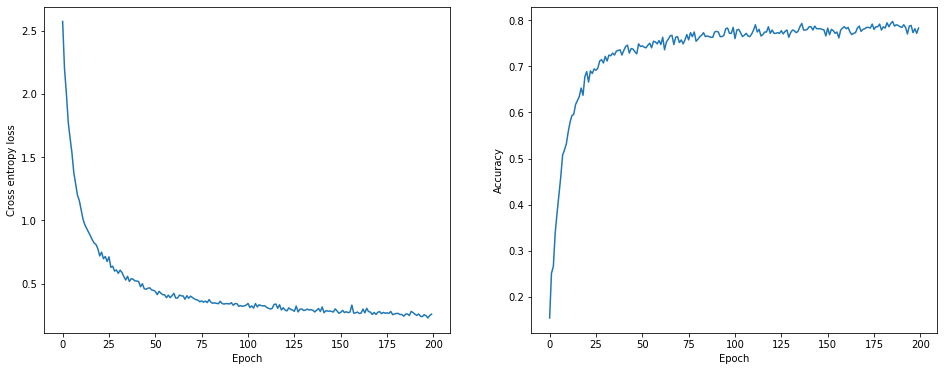

In [14]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-gru-dropout"] = stats

##### word-level GRU with dropouts

iter: 0   | train_loss: 2.65146 | test_acc: 0.07143
iter: 50  | train_loss: 0.00194 | test_acc: 0.92143
iter: 100 | train_loss: 0.00003 | test_acc: 0.91714
iter: 150 | train_loss: 0.00067 | test_acc: 0.90571
iter: 199 | train_loss: 0.00001 | test_acc: 0.89286
Done. (Total time taken: 612.63 seconds | Highest test accuracy: 0.93714 at epoch 105)



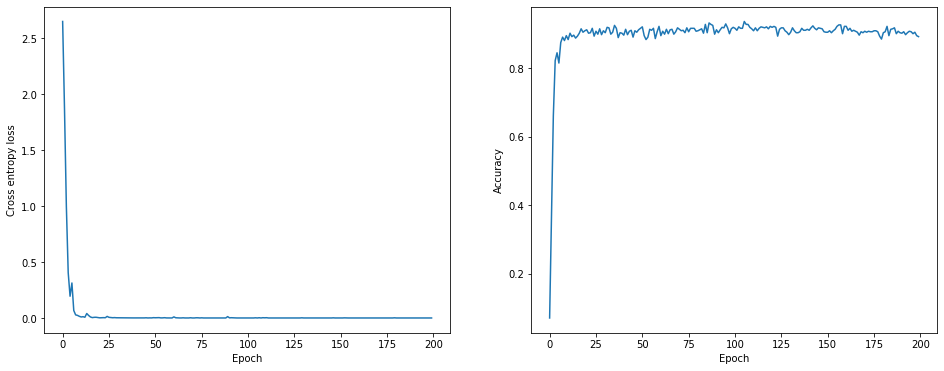

In [15]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
vocab_size = np.amax(x_train) + 1
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, embedding_dim=20)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-gru-dropout"] = stats

##### Plot comparison graphs

In [16]:
list(STATISTICS.keys())

['char-cnn',
 'word-cnn',
 'char-gru',
 'word-gru',
 'char-cnn-dropout',
 'word-cnn-dropout',
 'char-gru-dropout',
 'word-gru-dropout']

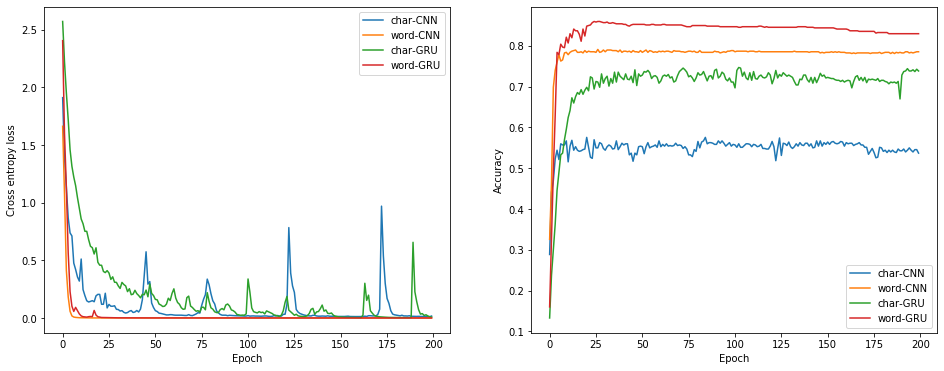

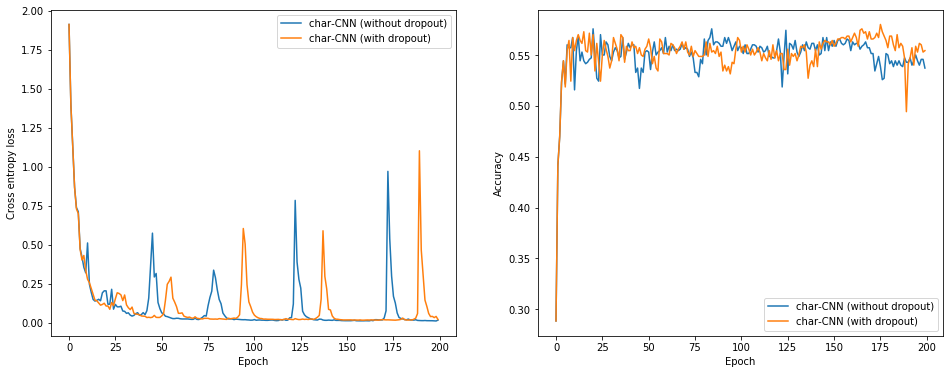

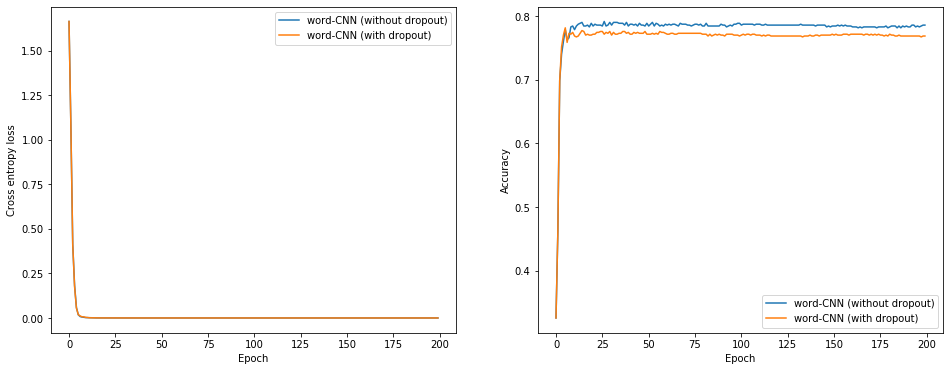

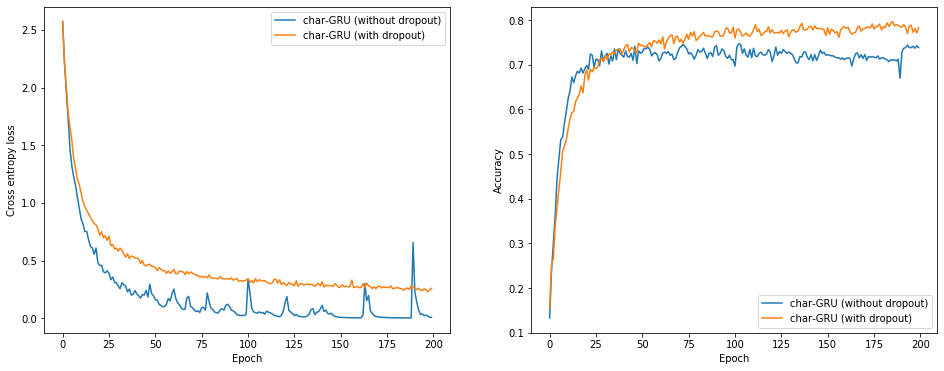

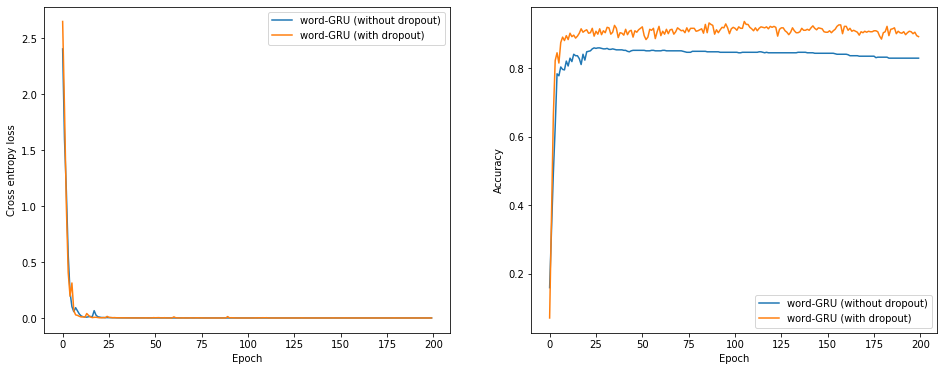

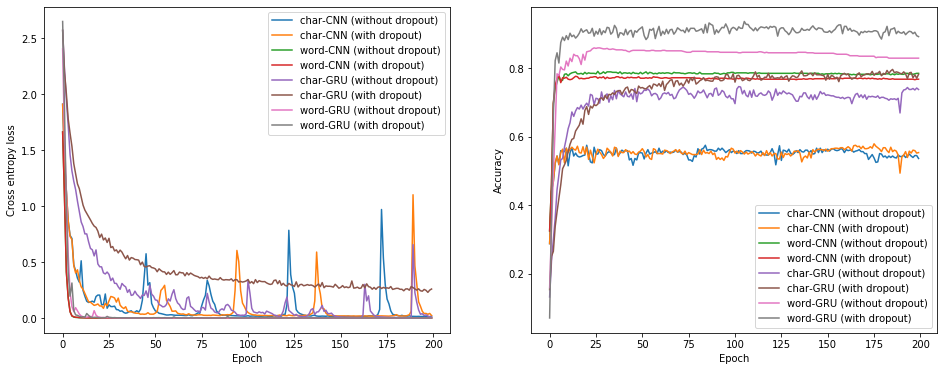

In [17]:
# char-CNN vs word-CNN vs char-GRU vs word-GRU
plot_graphs([STATISTICS["char-cnn"], STATISTICS["word-cnn"], 
             STATISTICS["char-gru"], STATISTICS["word-gru"]],
            ["char-CNN",  "word-CNN", "char-GRU", "word-GRU"])

# char-CNN without dropout vs char-CNN with dropout
plot_graphs([STATISTICS["char-cnn"], STATISTICS["char-cnn-dropout"]],
            ["char-CNN (without dropout)", "char-CNN (with dropout)"])

# word-CNN without dropout vs word-CNN with dropout
plot_graphs( [STATISTICS["word-cnn"], STATISTICS["word-cnn-dropout"]],
            ["word-CNN (without dropout)", "word-CNN (with dropout)"])

# char-GRU without dropout vs char-GRU with dropout
plot_graphs([STATISTICS["char-gru"], STATISTICS["char-gru-dropout"]],
            ["char-GRU (without dropout)", "char-GRU (with dropout)"])

# word-GRU without dropout vs word-GRU with dropout
plot_graphs([STATISTICS["word-gru"], STATISTICS["word-gru-dropout"]],
            ["word-GRU (without dropout)", "word-GRU (with dropout)"])

# all in one graph
plot_graphs([STATISTICS["char-cnn"], STATISTICS["char-cnn-dropout"],
             STATISTICS["word-cnn"], STATISTICS["word-cnn-dropout"],
             STATISTICS["char-gru"], STATISTICS["char-gru-dropout"],
             STATISTICS["word-gru"], STATISTICS["word-gru-dropout"]],
            ["char-CNN (without dropout)", "char-CNN (with dropout)", 
             "word-CNN (without dropout)", "word-CNN (with dropout)",
             "char-GRU (without dropout)", "char-GRU (with dropout)",
             "word-GRU (without dropout)", "word-GRU (with dropout)"])

### Change types of RNN layer

##### character-level RNN

iter: 0   | train_loss: 2.60054 | test_acc: 0.08714
iter: 50  | train_loss: 2.46561 | test_acc: 0.13000
iter: 100 | train_loss: 2.44779 | test_acc: 0.11143
iter: 150 | train_loss: 2.60142 | test_acc: 0.08857
iter: 199 | train_loss: 2.57300 | test_acc: 0.10000
Done. (Total time taken: 199.61 seconds | Highest test accuracy: 0.16286 at epoch 105)



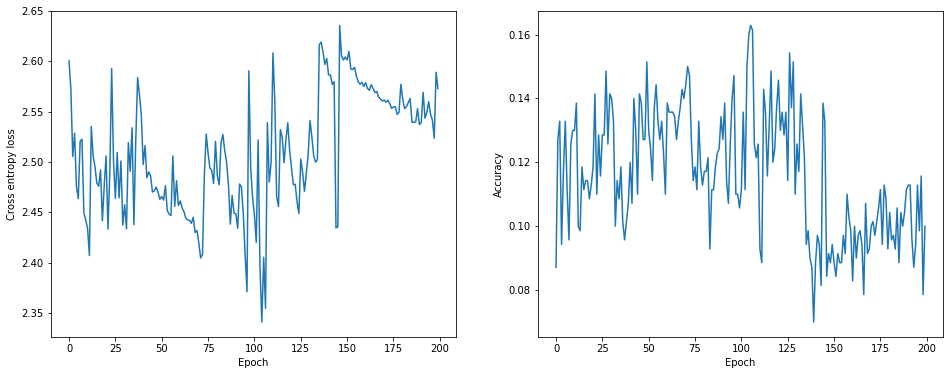

In [18]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE, num_layers=1, cell_type='vanilla', embedding_dim=None)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-rnn-dropout"] = stats

##### word-level RNN

iter: 0   | train_loss: 2.65485 | test_acc: 0.07143
iter: 50  | train_loss: 2.63413 | test_acc: 0.07143
iter: 100 | train_loss: 2.63389 | test_acc: 0.07143
iter: 150 | train_loss: 2.64768 | test_acc: 0.07143
iter: 199 | train_loss: 2.63578 | test_acc: 0.09714
Done. (Total time taken: 272.43 seconds | Highest test accuracy: 0.11286 at epoch 165)



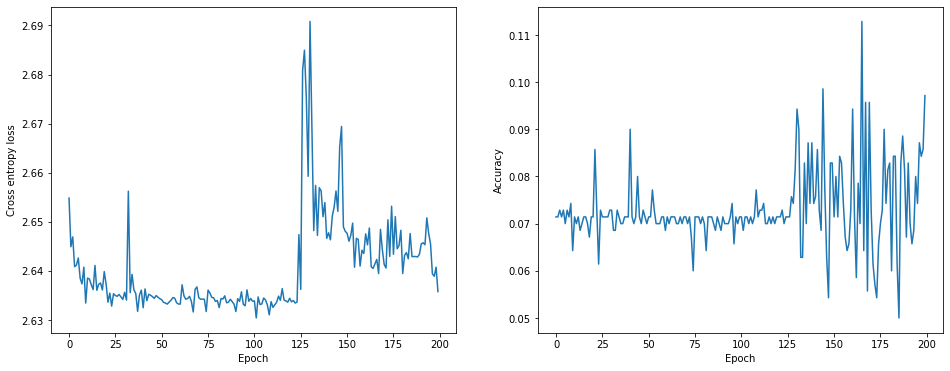

In [19]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
vocab_size = np.amax(x_train) + 1
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, num_layers=1, cell_type='vanilla', embedding_dim=20)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
gradient_clipping_threshold = 2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-rnn-dropout"] = stats

##### character-level LSTM

iter: 0   | train_loss: 2.52432 | test_acc: 0.16000
iter: 50  | train_loss: 0.45080 | test_acc: 0.74857
iter: 100 | train_loss: 0.28377 | test_acc: 0.79143
iter: 150 | train_loss: 0.22261 | test_acc: 0.80857
iter: 199 | train_loss: 0.18757 | test_acc: 0.78571
Done. (Total time taken: 457.05 seconds | Highest test accuracy: 0.82429 at epoch 151)



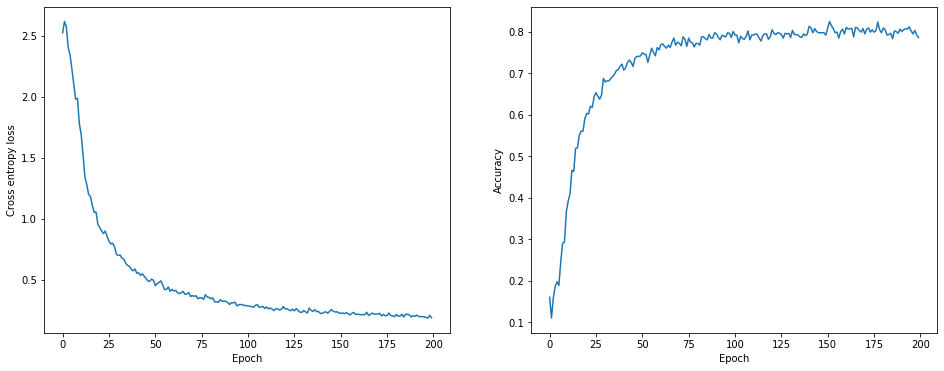

In [20]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE, num_layers=1, cell_type='lstm', embedding_dim=None)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-lstm-dropout"] = stats

##### word-level LSTM

iter: 0   | train_loss: 2.65238 | test_acc: 0.07143
iter: 50  | train_loss: 0.53606 | test_acc: 0.54857
iter: 100 | train_loss: 0.01308 | test_acc: 0.77286
iter: 150 | train_loss: 0.00539 | test_acc: 0.76286
iter: 199 | train_loss: 0.00461 | test_acc: 0.80143
Done. (Total time taken: 541.34 seconds | Highest test accuracy: 0.81000 at epoch 184)



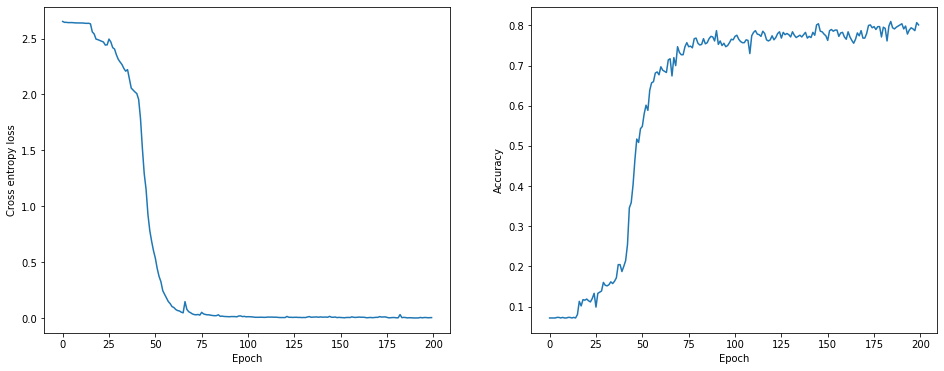

In [21]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
vocab_size = np.amax(x_train) + 1
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, num_layers=1, cell_type='lstm', embedding_dim=20)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-lstm-dropout"] = stats

##### Plot comparison graphs

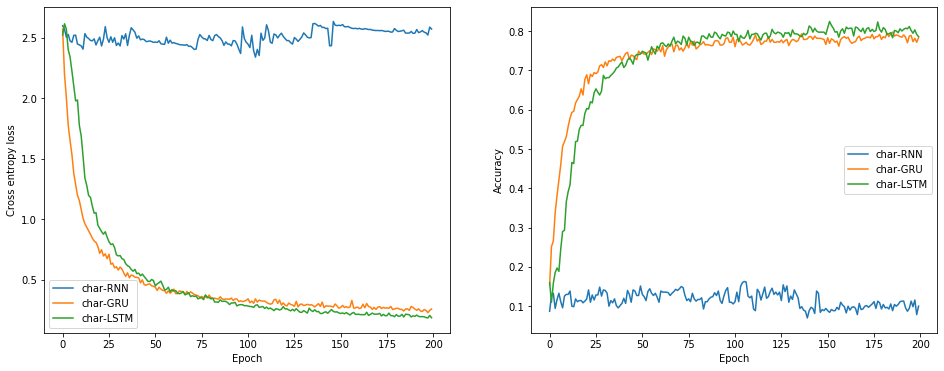

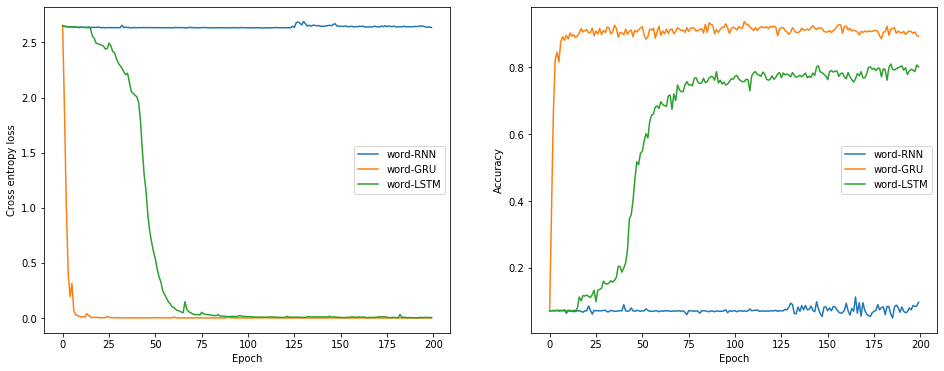

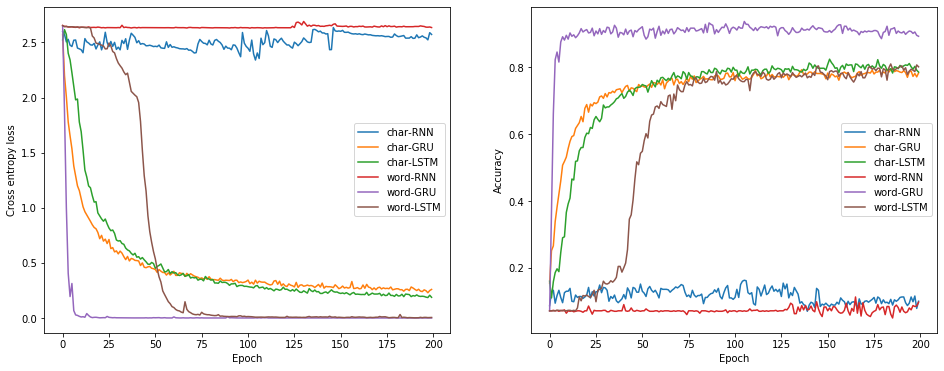

In [22]:
# char-RNN vs char-GRU vs char-LSTM
plot_graphs([STATISTICS["char-rnn-dropout"], 
             STATISTICS["char-gru-dropout"], 
             STATISTICS["char-lstm-dropout"]],
            ["char-RNN", "char-GRU", "char-LSTM"])

# word-RNN vs word-GRU vs word-LSTM
plot_graphs([STATISTICS["word-rnn-dropout"], 
             STATISTICS["word-gru-dropout"], 
             STATISTICS["word-lstm-dropout"]],
            ["word-RNN", "word-GRU", "word-LSTM"])

# char-RNN vs char-GRU vs char-LSTM vs word-RNN vs word-GRU vs word-LSTM
plot_graphs([STATISTICS["char-rnn-dropout"], 
             STATISTICS["char-gru-dropout"], 
             STATISTICS["char-lstm-dropout"],
             STATISTICS["word-rnn-dropout"], 
             STATISTICS["word-gru-dropout"], 
             STATISTICS["word-lstm-dropout"]],
            ["char-RNN", "char-GRU", "char-LSTM", 
             "word-RNN", "word-GRU", "word-LSTM"])

### Increase number of RNN layers

##### character-level GRU with 2 layers

iter: 0   | train_loss: 2.41429 | test_acc: 0.17714
iter: 50  | train_loss: 0.31338 | test_acc: 0.78286
iter: 100 | train_loss: 0.21820 | test_acc: 0.79000
iter: 150 | train_loss: 0.17621 | test_acc: 0.80571
iter: 199 | train_loss: 0.16566 | test_acc: 0.80714
Done. (Total time taken: 1306.81 seconds | Highest test accuracy: 0.82857 at epoch 179)



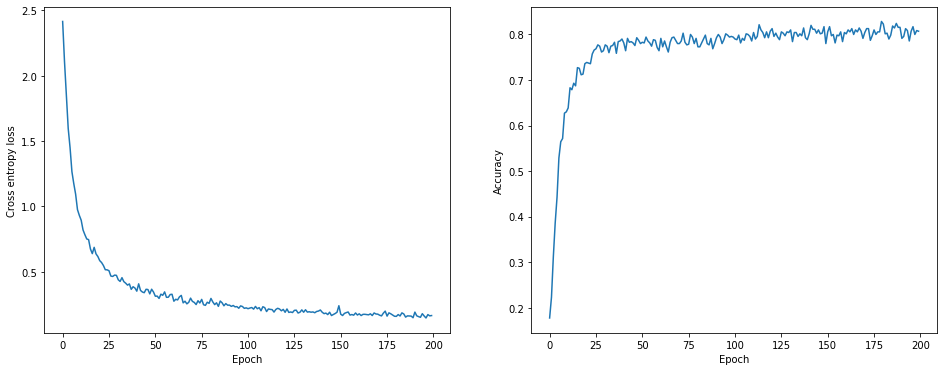

In [23]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE, num_layers=2, cell_type='gru', embedding_dim=None)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-gru-dropout-2layers"] = stats

##### word-level GRU with 2 layers

iter: 0   | train_loss: 2.11340 | test_acc: 0.15143
iter: 50  | train_loss: 0.00272 | test_acc: 0.86429
iter: 100 | train_loss: 0.00010 | test_acc: 0.86286
iter: 150 | train_loss: 0.00018 | test_acc: 0.90286
iter: 199 | train_loss: 0.00013 | test_acc: 0.92286
Done. (Total time taken: 1337.83 seconds | Highest test accuracy: 0.92857 at epoch 167)



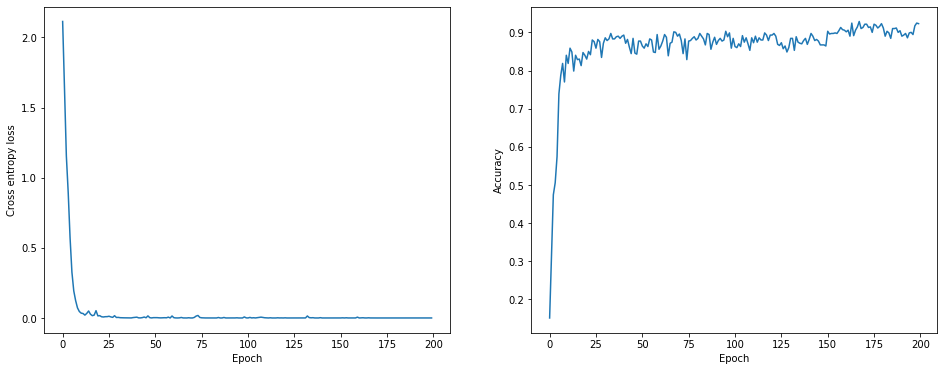

In [24]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
vocab_size = np.amax(x_train) + 1
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, num_layers=2, cell_type='gru', embedding_dim=20)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-gru-dropout-2layers"] = stats

##### Plot comparison graphs

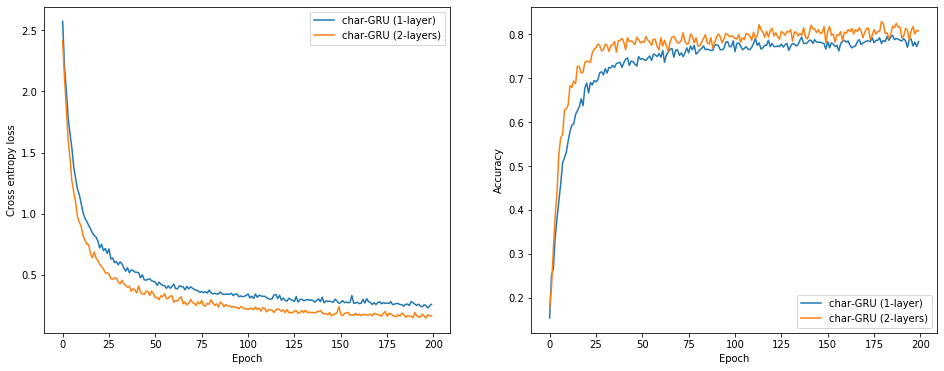

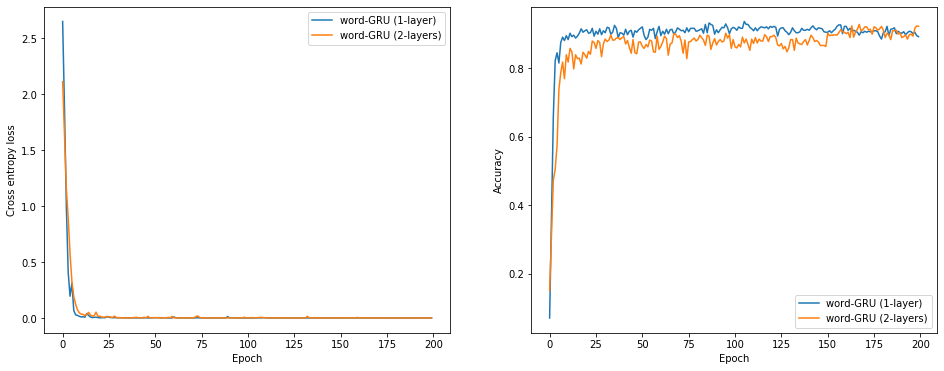

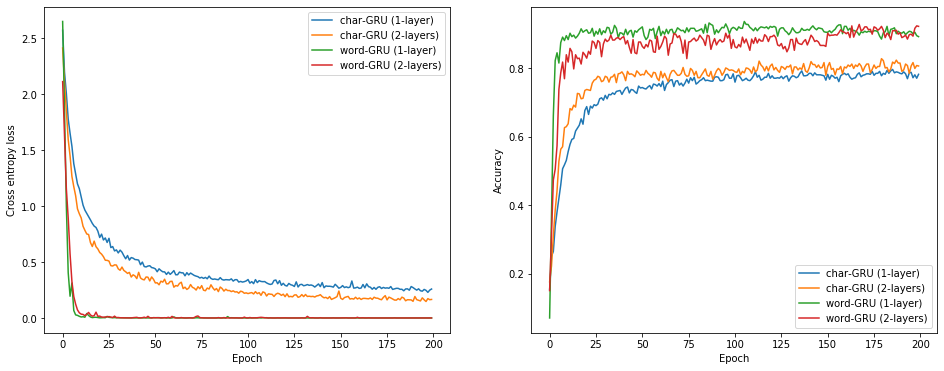

In [25]:
# 1-layer char-GRU vs 2-layers char-GRU
plot_graphs([STATISTICS["char-gru-dropout"], 
             STATISTICS["char-gru-dropout-2layers"]],
            ["char-GRU (1-layer)", "char-GRU (2-layers)"])

# 1-layer word-GRU vs 2-layers word-GRU
plot_graphs( [STATISTICS["word-gru-dropout"], 
             STATISTICS["word-gru-dropout-2layers"]],
            ["word-GRU (1-layer)", "word-GRU (2-layers)"])

# 1-layer char-GRU vs 2-layers char-GRU vs 1-layer word-GRU vs 2-layers word-GRU
plot_graphs( [STATISTICS["char-gru-dropout"], 
             STATISTICS["char-gru-dropout-2layers"],
             STATISTICS["word-gru-dropout"], 
             STATISTICS["word-gru-dropout-2layers"]],
            ["char-GRU (1-layer)", "char-GRU (2-layers)", 
             "word-GRU (1-layer)", "word-GRU (2-layers)"])

### Add gradient clipping

##### character-level GRU with gradient clipping

iter: 0   | train_loss: 2.40479 | test_acc: 0.17429
iter: 50  | train_loss: 0.34797 | test_acc: 0.76143
iter: 100 | train_loss: 0.23269 | test_acc: 0.79000
iter: 150 | train_loss: 0.17289 | test_acc: 0.81857
iter: 199 | train_loss: 0.14653 | test_acc: 0.83000
Done. (Total time taken: 1249.83 seconds | Highest test accuracy: 0.84143 at epoch 161)



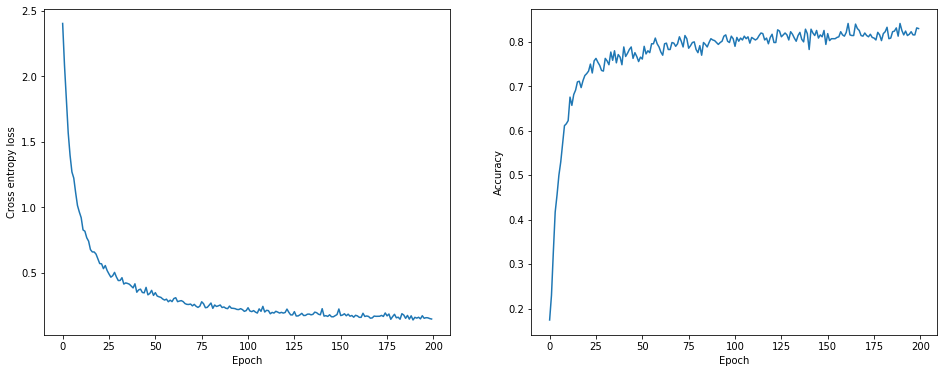

In [26]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='char')

# 3. define neural network architecture
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, VOCAB_SIZE, num_layers=2, cell_type='gru', embedding_dim=None)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
gradient_clipping_threshold = 2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              gradient_clipping_threshold=gradient_clipping_threshold, dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["char-gru-dropout-2layers-clip"] = stats

##### word-level GRU with gradient clipping

iter: 0   | train_loss: 2.65146 | test_acc: 0.07143
iter: 50  | train_loss: 0.00010 | test_acc: 0.92571
iter: 100 | train_loss: 0.00006 | test_acc: 0.91714
iter: 150 | train_loss: 0.00002 | test_acc: 0.92000
iter: 199 | train_loss: 0.00001 | test_acc: 0.91143
Done. (Total time taken: 564.98 seconds | Highest test accuracy: 0.93857 at epoch 131)



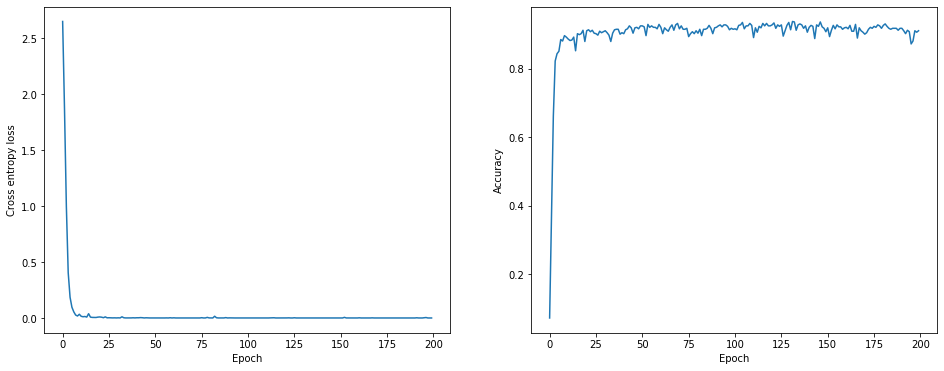

In [27]:
# 1. reset tensorflow session
reset_states()

# 2. load training and testing data
x_train, y_train, x_test, y_test = read_data(MAX_SEQUENCE_LENGTH, granularity='word')

# 3. define neural network architecture
vocab_size = np.amax(x_train) + 1
model = RNN(20, NUM_LABEL, MAX_SEQUENCE_LENGTH, vocab_size, num_layers=1, cell_type='gru', embedding_dim=20)

# 4. train neural network
num_epochs = 200
dropout_rate = 0.2
gradient_clipping_threshold = 2
stats = train(model, num_epochs, LEARING_RATE, BATCH_SIZE, x_train, y_train, x_test, y_test, 
              gradient_clipping_threshold=gradient_clipping_threshold, dropout_rate=dropout_rate)

# 5. plot training loss and testing accuracy
plot_graphs([stats])
STATISTICS["word-gru-dropout-2layers-clip"] = stats

##### Plot comparison graphs

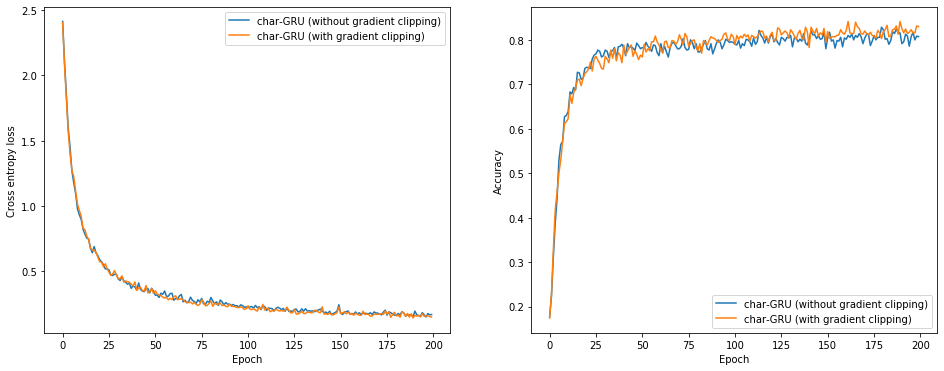

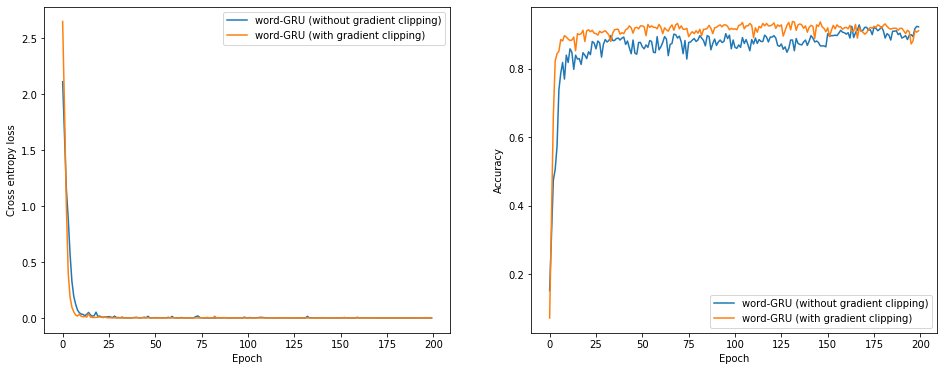

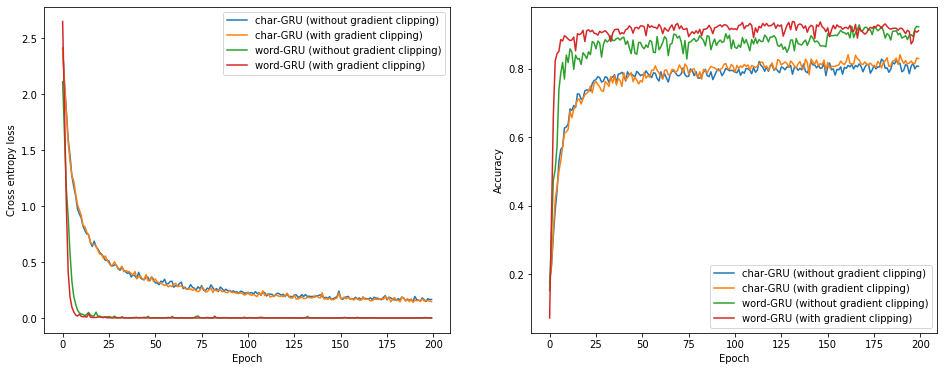

In [28]:
# char-GRU without clipping vs char-GRU with clipping
plot_graphs( [STATISTICS["char-gru-dropout-2layers"], 
             STATISTICS["char-gru-dropout-2layers-clip"]],
            ["char-GRU (without gradient clipping)", "char-GRU (with gradient clipping)"])

# word-GRU without clipping vs word-GRU with clipping
plot_graphs( [STATISTICS["word-gru-dropout-2layers"], 
             STATISTICS["word-gru-dropout-2layers-clip"]],
            ["word-GRU (without gradient clipping)", "word-GRU (with gradient clipping)"])

# char-GRU without clipping vs char-GRU with clipping vs word-GRU without clipping vs word-GRU with clipping
plot_graphs([STATISTICS["char-gru-dropout-2layers"], 
             STATISTICS["char-gru-dropout-2layers-clip"],
             STATISTICS["word-gru-dropout-2layers"], 
             STATISTICS["word-gru-dropout-2layers-clip"]],
            ["char-GRU (without gradient clipping)", 
             "char-GRU (with gradient clipping)", 
             "word-GRU (without gradient clipping)", 
             "word-GRU (with gradient clipping)"])